In [37]:
import DGM
import tensorflow as tf
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt

from dadi import Numerics, PhiManip, Integration, Spectrum

In [38]:
# PDE domain
t_low = 10e-13    # time lower bound
T = 1 - 10e-13 # time upper bound
x_low = 0.0 + 10e-13  # X lower bound
x_high = 1 - 10e-13   # X upper bound

# Parameters domains
nu_low = 40.0
nu_high = 50.0
gamma_low = -2.0
gamma_high = 2.0
theta_low = 1.0
theta_high = 1.5

# NN parameters
num_layers = 3
nodes_per_layer = 30
learning_rate = 0.001

# Training parameters
sampling_stages  = 20   # number of times to resample new time-space domain points
steps_per_sample = 100    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_interior = 5000
nSim_terminal = 5000

In [39]:
def WrightFisherInitial(x, theta, gamma, nu):
    return nu * theta*(1-np.exp(-2*gamma*(1-x)))/(1-np.exp(-2*gamma))
    #return theta * np.exp(2*gamma)*(1 - np.exp(-2*gamma*(1-x)))/(np.exp(2*gamma) - 1)

In [40]:
def sampler(nSim_interior, nSim_terminal):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at terminal time to sample (terminal condition)
    ''' 
    
    # Sampler #1: PDE domain interior
    t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
    x_interior = np.random.uniform(low=x_low, high=x_high, size=[nSim_interior, 1])

    # Sampler #2: boundary
    t_boundary = np.random.uniform(low=t_low, high=T, size=[nSim_terminal, 1])
    x_boundary = np.linspace(0, 10e-5, nSim_terminal).reshape(-1,1)
    #np.random.uniform(low=10e-5, high=x_low + 10e-5, size=[nSim_terminal, 1]) #np.zeros(shape=(nSim_terminal, 1))  
    x_boundary_last =  np.linspace(x_high, x_high, nSim_terminal).reshape(-1,1)   

    # Sampler #3: initial condition
    t_terminal = np.zeros(shape = (nSim_terminal, 1))
    x_terminal = np.random.uniform(low=0, high=1, size = [nSim_terminal, 1])

    # Sampler #4: parameters interior
    gamma_interior = np.random.uniform(low=gamma_low, high=gamma_high, size=[nSim_interior, 1])
    theta_interior = np.random.uniform(low=theta_low, high=theta_high, size=[nSim_interior, 1])
    nu_interior = np.random.uniform(low=nu_low, high=nu_high, size=[nSim_interior, 1])


    return t_interior, x_interior, t_terminal, x_terminal, t_boundary, x_boundary, x_boundary_last, gamma_interior, theta_interior, nu_interior


In [41]:
def loss(model, t_interior, x_interior, 
                t_terminal, x_terminal,
                t_boundary, x_boundary, x_boundary_last,
                param_gamma, param_theta, param_nu):

    # Loss term #1: PDE
    V = model(t_interior, [x_interior], [param_gamma, param_theta, param_nu])
    V_t = tf.gradients(V, t_interior)[0] #du/dt
    V_s = tf.gradients(V, x_interior)[0] #du/dx
    V_ss = tf.gradients(V_s, x_interior)[0] #d^2u/dx^2

    b = x_interior*(1-x_interior)/(2*param_nu)
    a = param_gamma * x_interior*(1-x_interior)

    diff_V = V_t - b * V_ss + a * V_s

    L1 = tf.reduce_mean(tf.square(diff_V)) 
    
    boundary_target_payoff = param_nu*param_theta
    boundary_fitted_payoff = model(t_interior, [x_boundary], [param_gamma, param_theta, param_nu])

    #gamma * 2*(h + (1.-2*h)*x) * x*(1.-x)
    #dx = x_boundary_last[-1] - x_boundary_last[2]
    #a_right = param_gamma * x_boundary_last*(1-x_boundary_last)
    
    boundary_fitted_right_payoff = model(t_interior, [x_boundary_last], [param_gamma, param_theta, param_nu])

    L2_left_boundary = tf.reduce_mean(tf.square(boundary_fitted_payoff - boundary_target_payoff))
    L2_right_boundary = tf.reduce_mean(tf.square(boundary_fitted_right_payoff)) 
    L2 = L2_left_boundary + L2_right_boundary
    
    # Loss term #3: initial/terminal condition
    target_payoff =  param_nu * param_theta*(1-tf.exp(-2*param_gamma*(1-x_terminal)))/(1-tf.exp(-2*param_gamma)) 
    #target_payoff = param_theta * tf.exp(2*param_gamma)*(1 - tf.exp(-2*param_gamma*(1-x_interior)))/(tf.exp(2*param_gamma) - 1)
    
    fitted_payoff = model(t_terminal, [x_terminal], [param_gamma, param_theta, param_nu])
    L3 = tf.reduce_mean( tf.square(fitted_payoff - target_payoff) )

    return L1, L2, L3


In [42]:
#3 - number of parameters
model = DGM.DGMNet(nodes_per_layer, num_layers, 1, 3)

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_interior_tnsr = tf.placeholder(tf.float32, [None,1])
x_interior_tnsr = tf.placeholder(tf.float32, [None,1])

t_initial_tnsr = tf.placeholder(tf.float32, [None,1])
x_initial_tnsr = tf.placeholder(tf.float32, [None,1])

t_boundary_tnsr = tf.placeholder(tf.float32, [None,1])
x_boundary_tnsr = tf.placeholder(tf.float32, [None,1])
x_boundary_last_tnsr = tf.placeholder(tf.float32, [None,1])

param_gamma_tnsr = tf.placeholder(tf.float32, [None, 1])
param_theta_tnsr = tf.placeholder(tf.float32, [None, 1])
param_nu_tnsr = tf.placeholder(tf.float32, [None, 1])

# loss 
L1_tnsr, L2_tnsr, L3_tnsr = loss(model, t_interior_tnsr, x_interior_tnsr, 
                                        t_initial_tnsr, x_initial_tnsr, 
                                        t_boundary_tnsr, x_boundary_tnsr, 
                                        x_boundary_last_tnsr,
                                        param_gamma_tnsr,
                                        param_theta_tnsr,
                                        param_nu_tnsr)
loss_tnsr = L1_tnsr + L2_tnsr + L3_tnsr

# option value function
V = model(t_interior_tnsr, [x_interior_tnsr], [param_gamma_tnsr, param_theta_tnsr, param_nu_tnsr])

# set optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.global_variables_initializer()

# open session
sess = tf.Session()
sess.run(init_op)


In [43]:
# for each sampling stage
for i in range(sampling_stages):
    
    # sample uniformly from the required regions
    t_interior, x_interior, t_initial, x_initial, t_boundary, x_boundary, x_boundary_last, param_gamma, param_theta, param_nu = sampler(nSim_interior, nSim_terminal)
    # for a given sample, take the required number of SGD steps
    for it in range(steps_per_sample):
        loss,L1,L2,L3,_ = sess.run([loss_tnsr, L1_tnsr, L2_tnsr, L3_tnsr, optimizer],
                                feed_dict = {t_interior_tnsr:t_interior, x_interior_tnsr:x_interior,
                                 t_initial_tnsr:t_initial, x_initial_tnsr:x_initial, 
                                 t_boundary_tnsr:t_boundary, x_boundary_tnsr:x_boundary, 
                                 x_boundary_last_tnsr:x_boundary_last,
                                 param_gamma_tnsr: param_gamma, param_theta_tnsr: param_theta, param_nu_tnsr: param_nu})
    
    print(f"#{i}: Total loss: {loss}, PDE loss: {L1}, Boundary loss: {L2}, Initial loss: {L3}")

#0: Total loss: 1881.17578125, PDE loss: 0.1891825646162033, Boundary loss: 1553.861572265625, Initial loss: 327.12506103515625
#1: Total loss: 604.5946044921875, PDE loss: 46.03593444824219, Boundary loss: 472.21087646484375, Initial loss: 86.34778594970703
#2: Total loss: 165.92388916015625, PDE loss: 24.26682472229004, Boundary loss: 104.6017074584961, Initial loss: 37.05535888671875
#3: Total loss: 90.41104888916016, PDE loss: 16.96232032775879, Boundary loss: 54.506832122802734, Initial loss: 18.94189453125
#4: Total loss: 55.883338928222656, PDE loss: 9.817198753356934, Boundary loss: 34.80821990966797, Initial loss: 11.257917404174805
#5: Total loss: 30.006202697753906, PDE loss: 6.605744361877441, Boundary loss: 17.836549758911133, Initial loss: 5.563907146453857
#6: Total loss: 22.835208892822266, PDE loss: 5.873414039611816, Boundary loss: 13.17386245727539, Initial loss: 3.787932872772217
#7: Total loss: 12.102663040161133, PDE loss: 3.44861102104187, Boundary loss: 6.676072

In [67]:
def CalcDadi(x_grid, initial_phi,p_t, p_gamma, p_theta, p_nu):
    phi = Integration.one_pop(initial_phi, x_grid, p_t, nu = p_nu, gamma = p_gamma, theta0 = p_theta, beta=1)
    return phi

def PlotSolutions(theta, gamma, nu, plot_afs = False):
    # LaTeX rendering for text in plots
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # figure options
    plt.figure()
    plt.figure(figsize = (50,10))

    if(plot_afs):
        plt.suptitle(f'AFS plots, PDE parameters: $\\theta$ = {theta}, $\gamma$ = {gamma}, $\\nu$ = {nu}', fontsize=27)
    else:
        plt.suptitle(f'Density function $f(x,t)$ plots, PDE parameters: $\\theta$ = {theta}, $\gamma$ = {gamma}, $\\nu$ = {nu}', fontsize=27)

    # time values at which to examine density
    times = [0, 0.1, 0.2, 0.6]

    # vector of t and S values for plotting
    x_plot = np.linspace(x_low, x_high, 20000)
    x_plot[0:150] = x_plot[150:300]/2

    for i, curr_t in enumerate(times):

        # specify subplot
        plt.subplot(1,4,i+1)
        
        # simulate process at current t 
        initial_u = WrightFisherInitial(x_plot, theta, gamma, nu)

        initial_phi = initial_u.reshape(1,-1)[0]/(x_plot*(1-x_plot))
        
        dadi_solution = CalcDadi(x_plot, initial_phi, curr_t, gamma, theta, nu)
        # compute normalized density at all x values to plot and current t value
        t_plot = curr_t * np.ones_like(x_plot.reshape(-1,1))
        fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, 
                                                    x_interior_tnsr:x_plot.reshape(-1,1),
                                                    param_gamma_tnsr:gamma * np.ones_like(x_plot.reshape(-1,1)),
                                                    param_theta_tnsr:theta * np.ones_like(x_plot.reshape(-1,1)),
                                                    param_nu_tnsr:nu * np.ones_like(x_plot.reshape(-1,1))})

        
        #/(x_plot*(1-x_plot))
        dgm_solution = fitted_optionValue[0].reshape(1,-1)[0]/(x_plot*(1-x_plot))
        
        spectrum_dadi = Spectrum.from_phi(dadi_solution.reshape(1,-1)[0][50:-50], (50,), (x_plot[50:-50],))
        spectrum_dgm = Spectrum.from_phi(dgm_solution.reshape(1,-1)[0][50:-50], (50,), (x_plot[50:-50],))

        if(plot_afs):
            plt.semilogy(spectrum_dadi, '-og', label='Dadi')
            plt.semilogy(spectrum_dgm, '-ob', label='DGM')
            rmse = np.sqrt(((spectrum_dadi - spectrum_dgm)**2).mean())
            plt.title(f"AFS for $t = {curr_t}, RMSE: {round(rmse,2)}$", fontsize=24, y=1.03)
        else:
            plt.plot(x_plot, initial_phi, color = 'r', label='Initial solution', linewidth = 3, linestyle=':')
            plt.plot(x_plot, dgm_solution, color = 'b', label='DGM estimate')    
            plt.plot(x_plot, dadi_solution, color = 'g', label='Dadi estimate')    
            rmse = np.sqrt(((dadi_solution[100:-100] - dgm_solution[100:-100])**2).mean())
            plt.title(f"$f(x, t = {curr_t}), RMSE: {round(rmse,2)}$", fontsize=24, y=1.03)
            plt.ylim(ymin=0, ymax=2000)
            plt.xlim(xmin=0, xmax=x_high)
            plt.xlabel(r"x", fontsize=15, labelpad=10)
            plt.ylabel(r"Frequency spectrum, f(x,t)", fontsize=15, labelpad=20)

        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.grid(linestyle=':')
        
        if i == 0:
            plt.legend(loc='upper left', prop={'size': 16})

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

## $\theta = 1.0$

### $\gamma = 1.3, \nu = 41.0$

<Figure size 432x288 with 0 Axes>

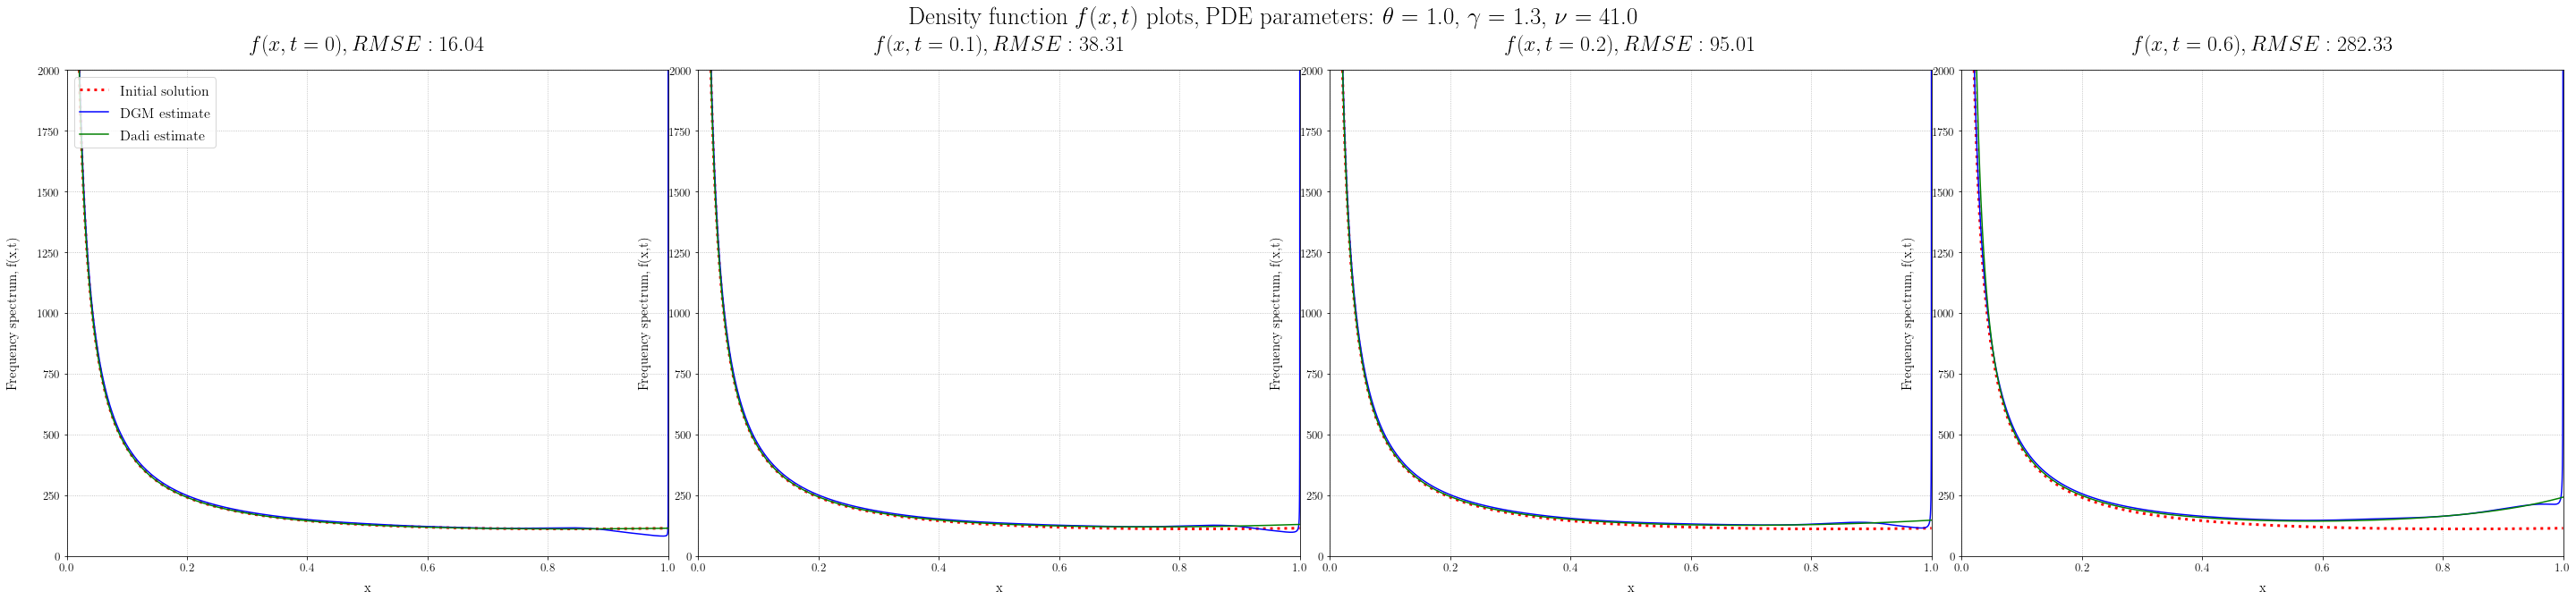

<Figure size 432x288 with 0 Axes>

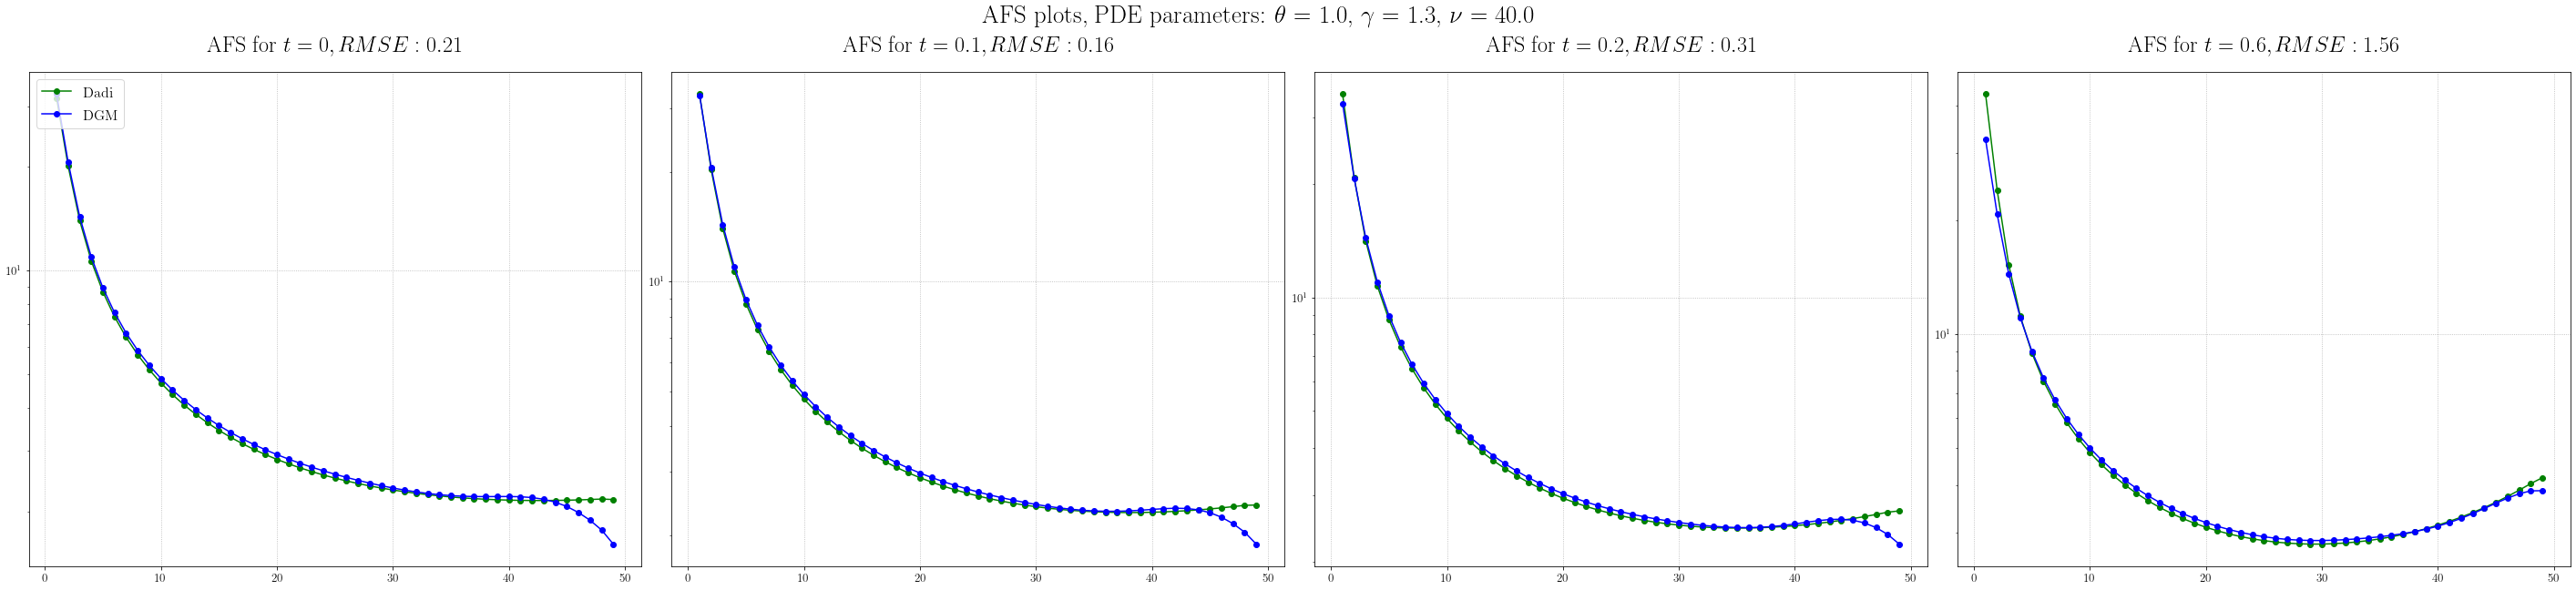

In [68]:
PlotSolutions(theta = 1.0, gamma =  1.3, nu = 41.0)
PlotSolutions(1.0, 1.3, 40.0, plot_afs=True)

### $\gamma = 1.3, \nu = 44.0$

<Figure size 432x288 with 0 Axes>

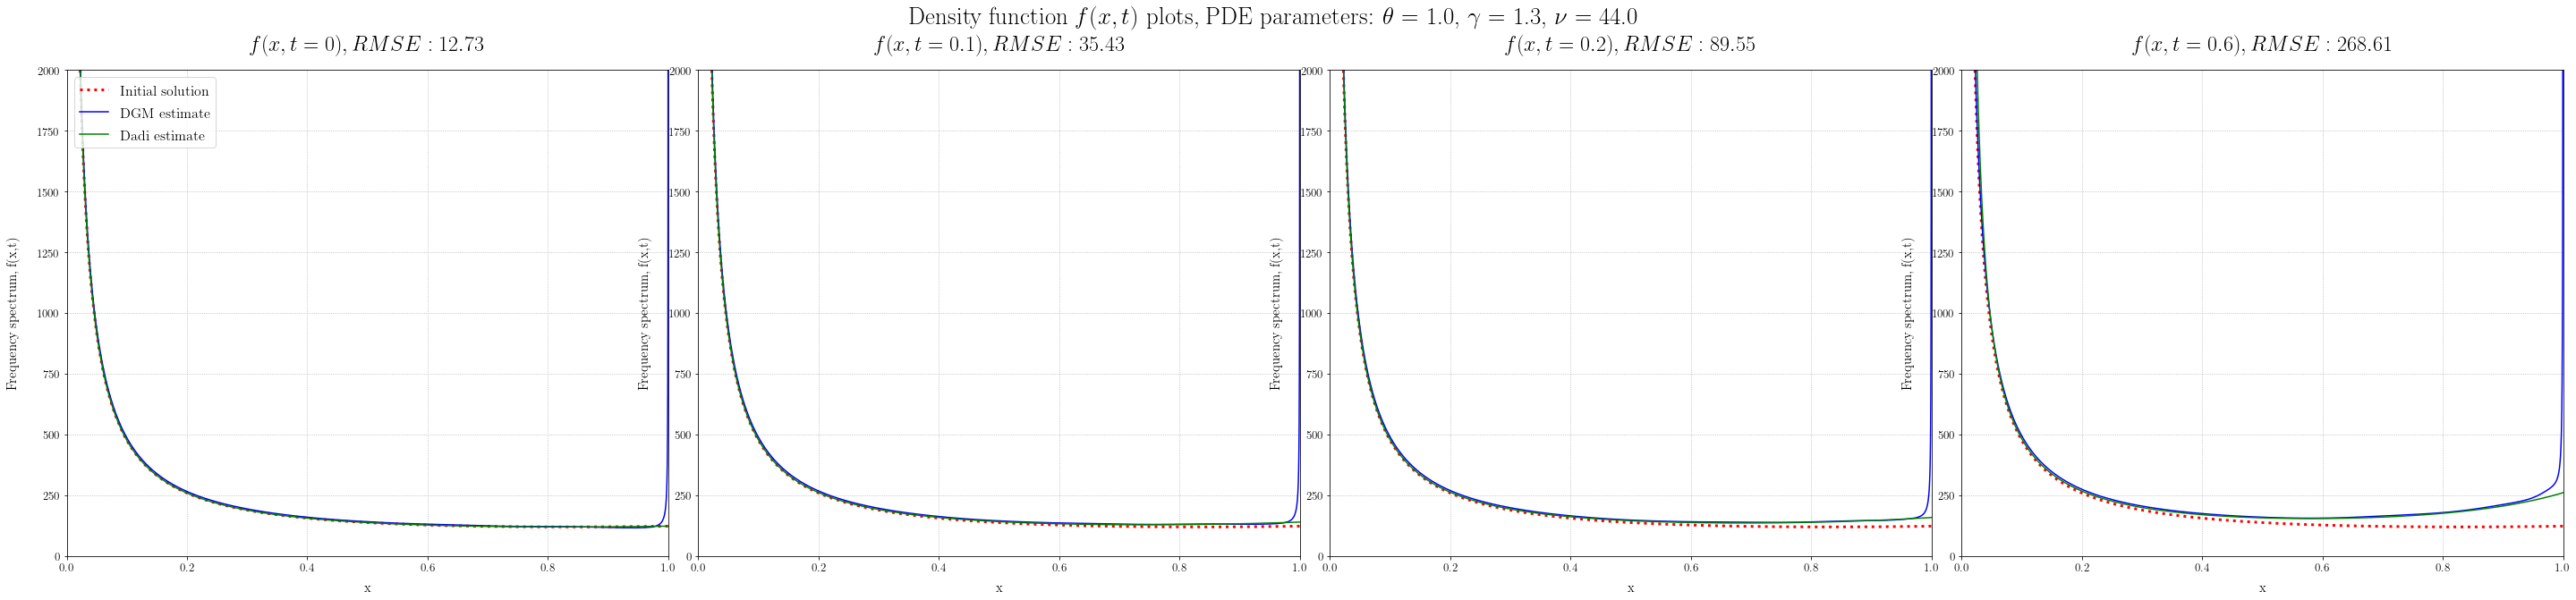

<Figure size 432x288 with 0 Axes>

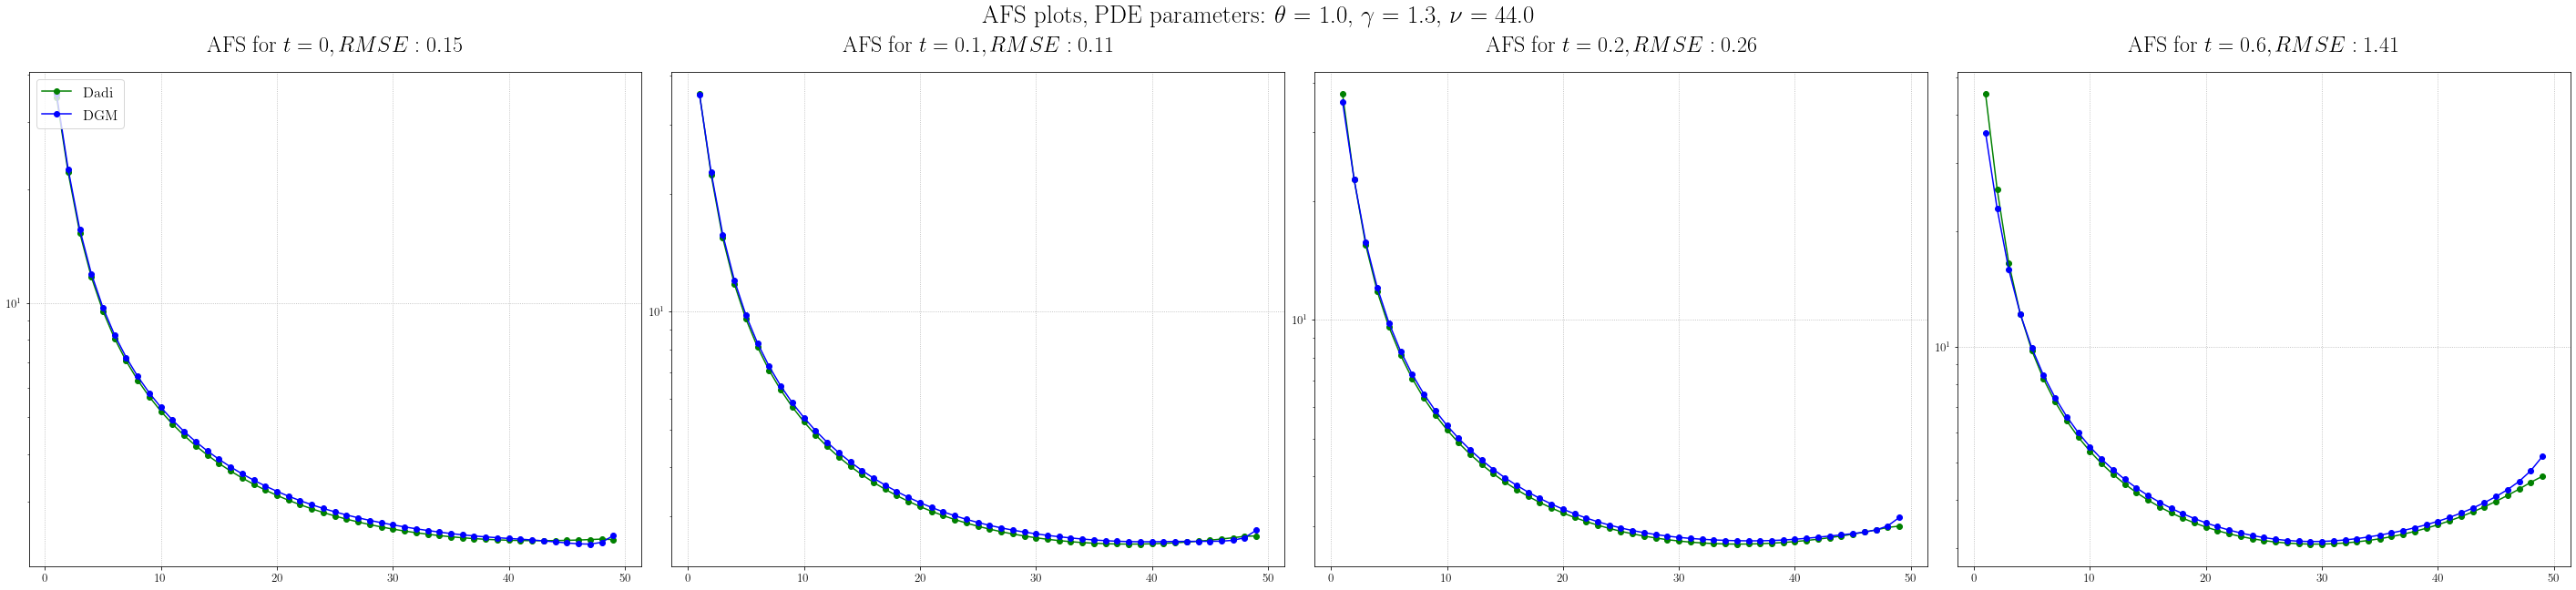

In [69]:
PlotSolutions(theta = 1.0, gamma =  1.3, nu = 44.0)
PlotSolutions(1.0, 1.3, 44.0, plot_afs=True)

### $\gamma = 1.3, \nu = 50.0$

<Figure size 432x288 with 0 Axes>

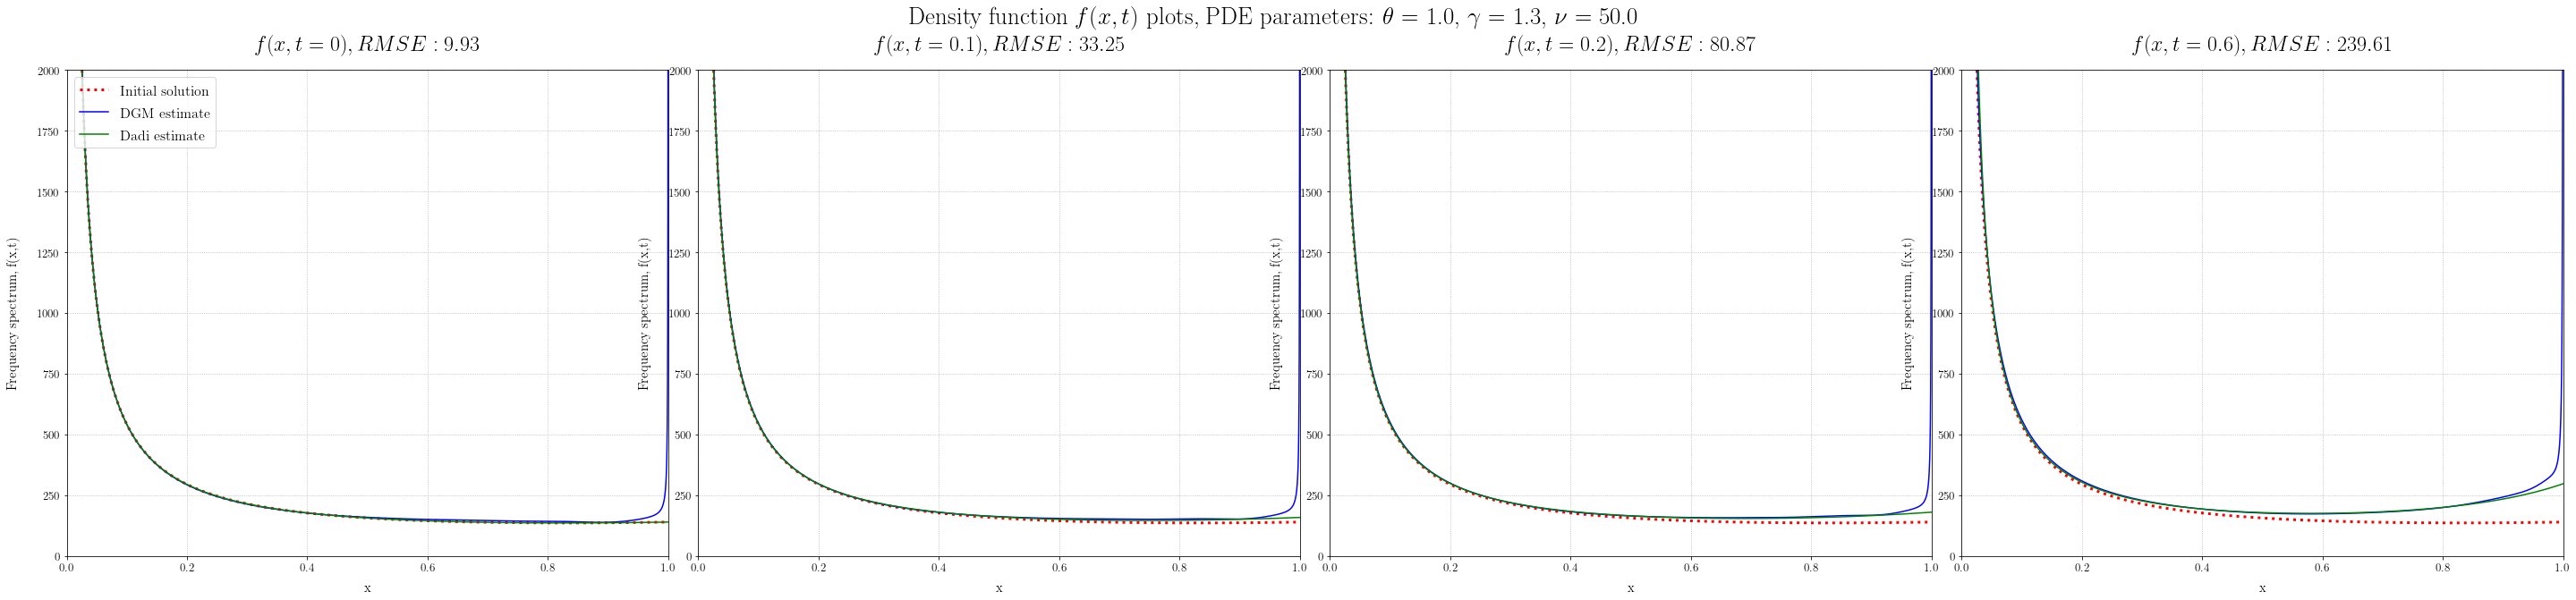

<Figure size 432x288 with 0 Axes>

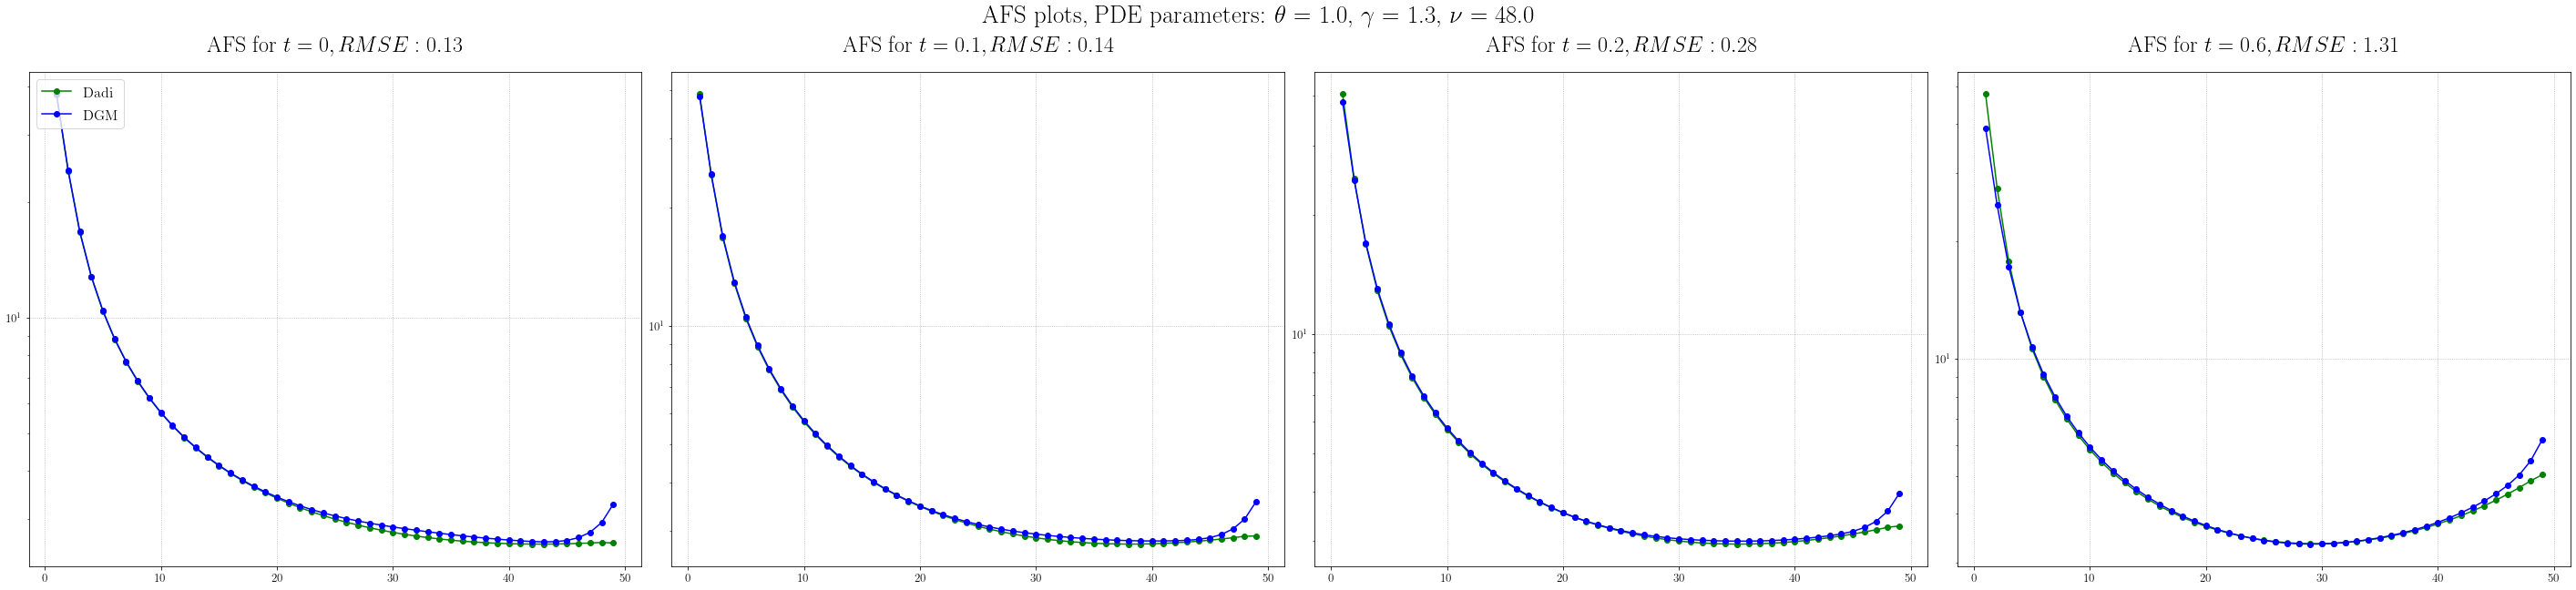

In [70]:
PlotSolutions(theta = 1.0, gamma =  1.3, nu = 50.0)
PlotSolutions(1.0, 1.3, 48.0, plot_afs=True)

### $\gamma = -1.3, \nu = 44.0$

<Figure size 432x288 with 0 Axes>

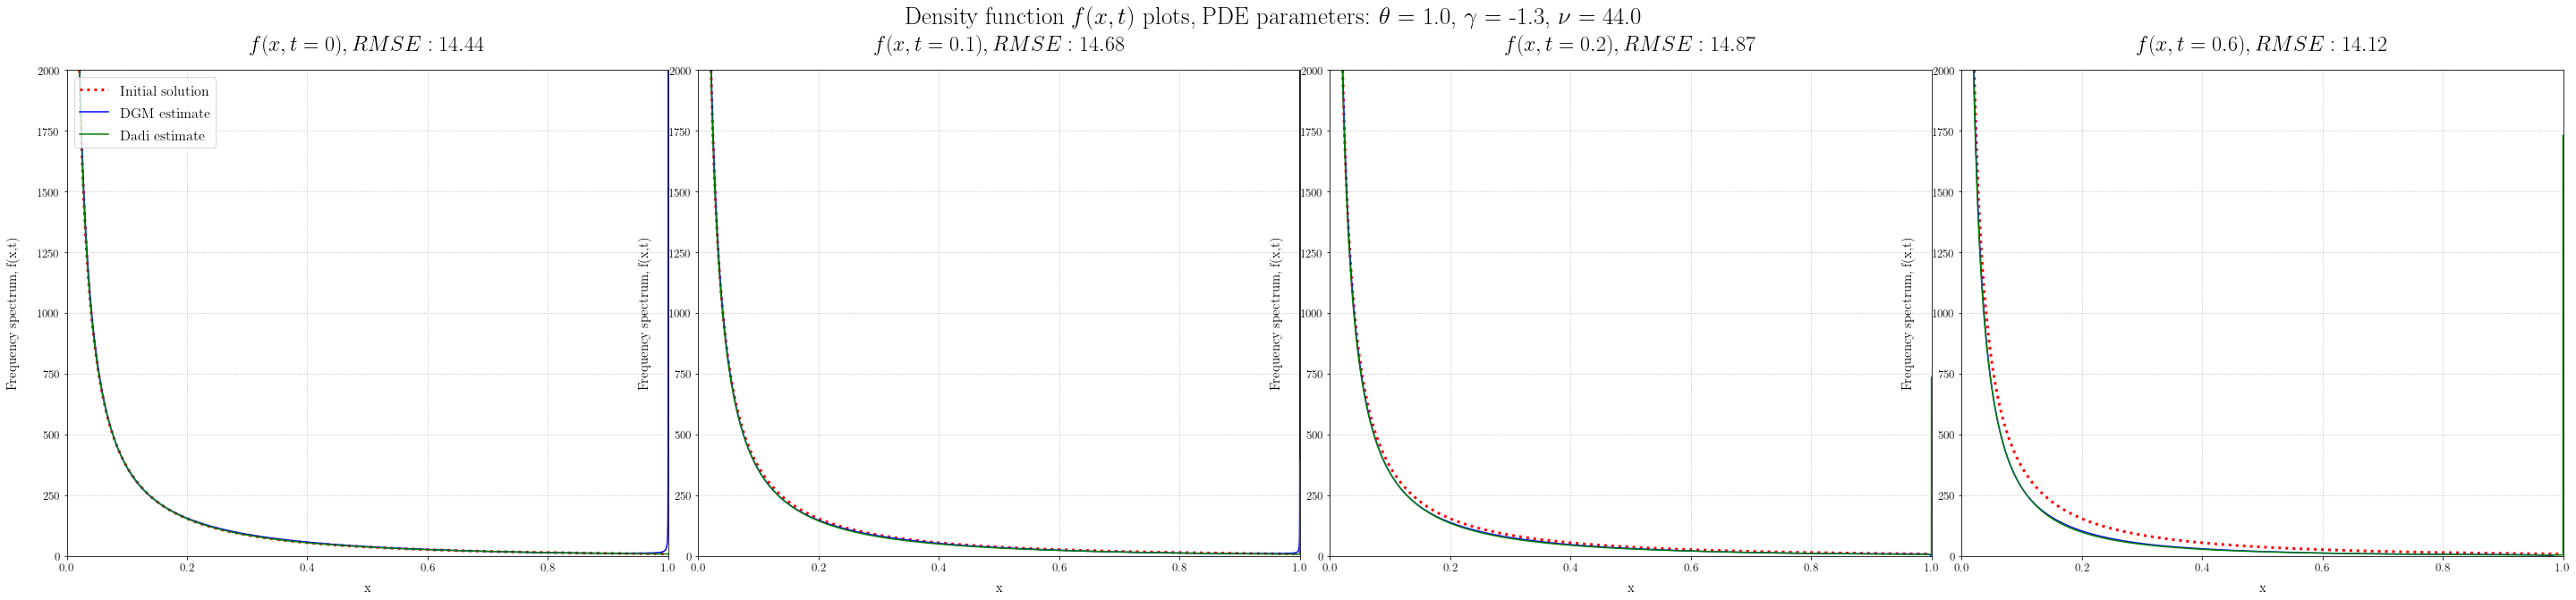

<Figure size 432x288 with 0 Axes>

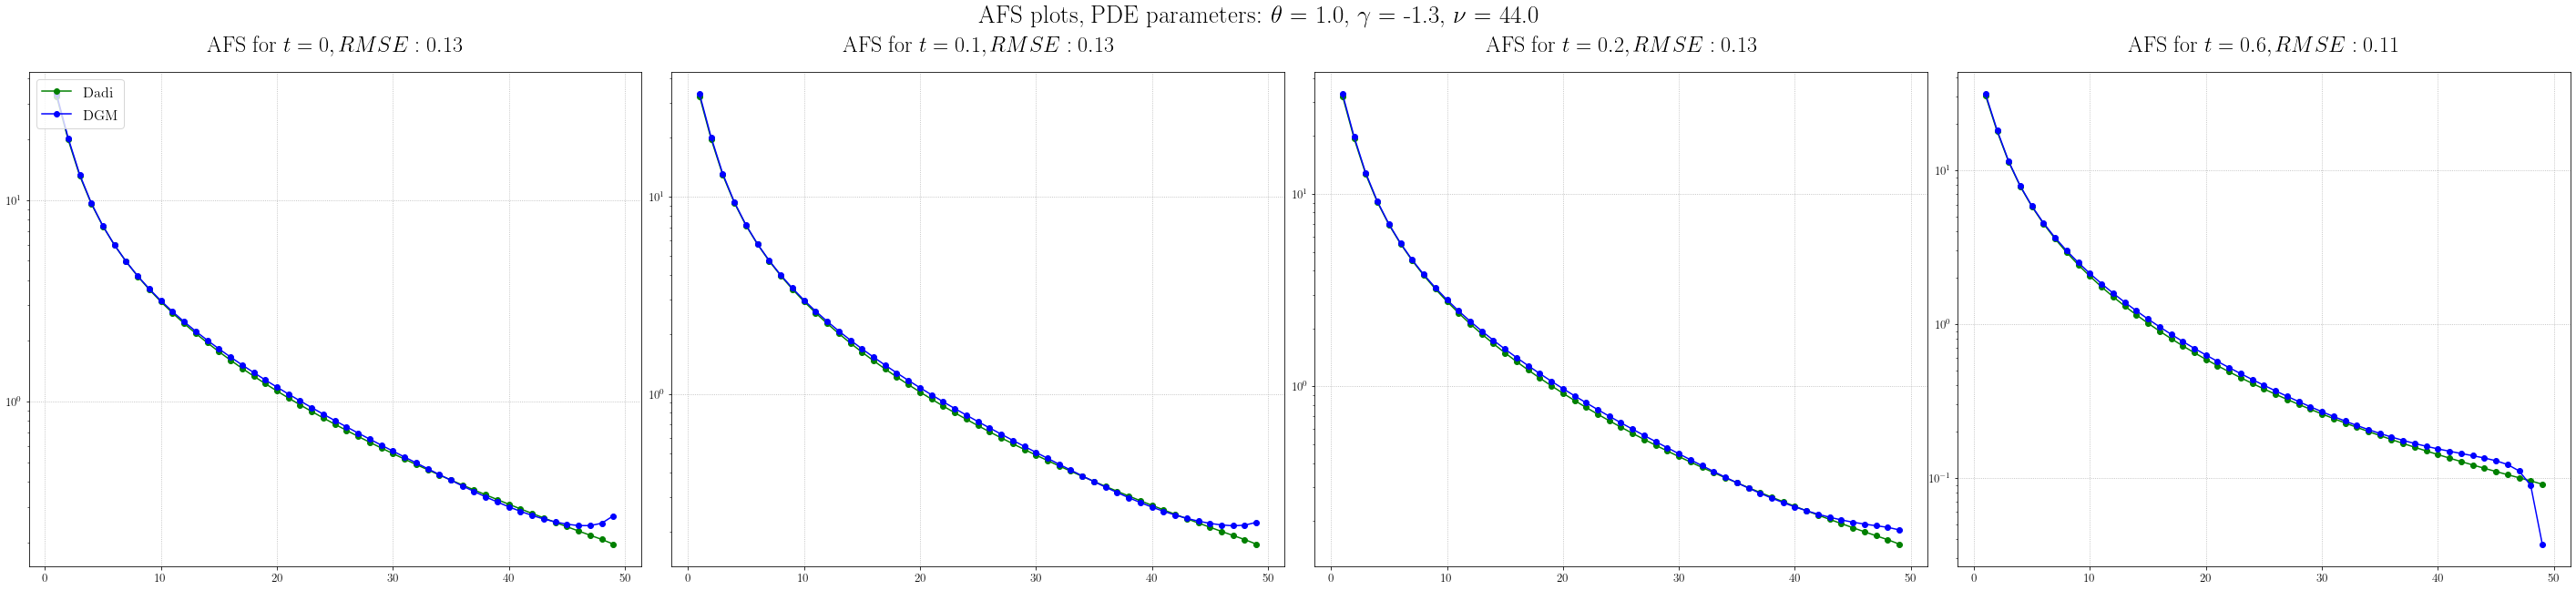

In [73]:
PlotSolutions(theta = 1.0, gamma =  -1.3, nu = 44.0)
PlotSolutions(1.0, -1.3, 44.0, plot_afs=True)

### $\gamma = -2, \nu = 44.0$

<Figure size 432x288 with 0 Axes>

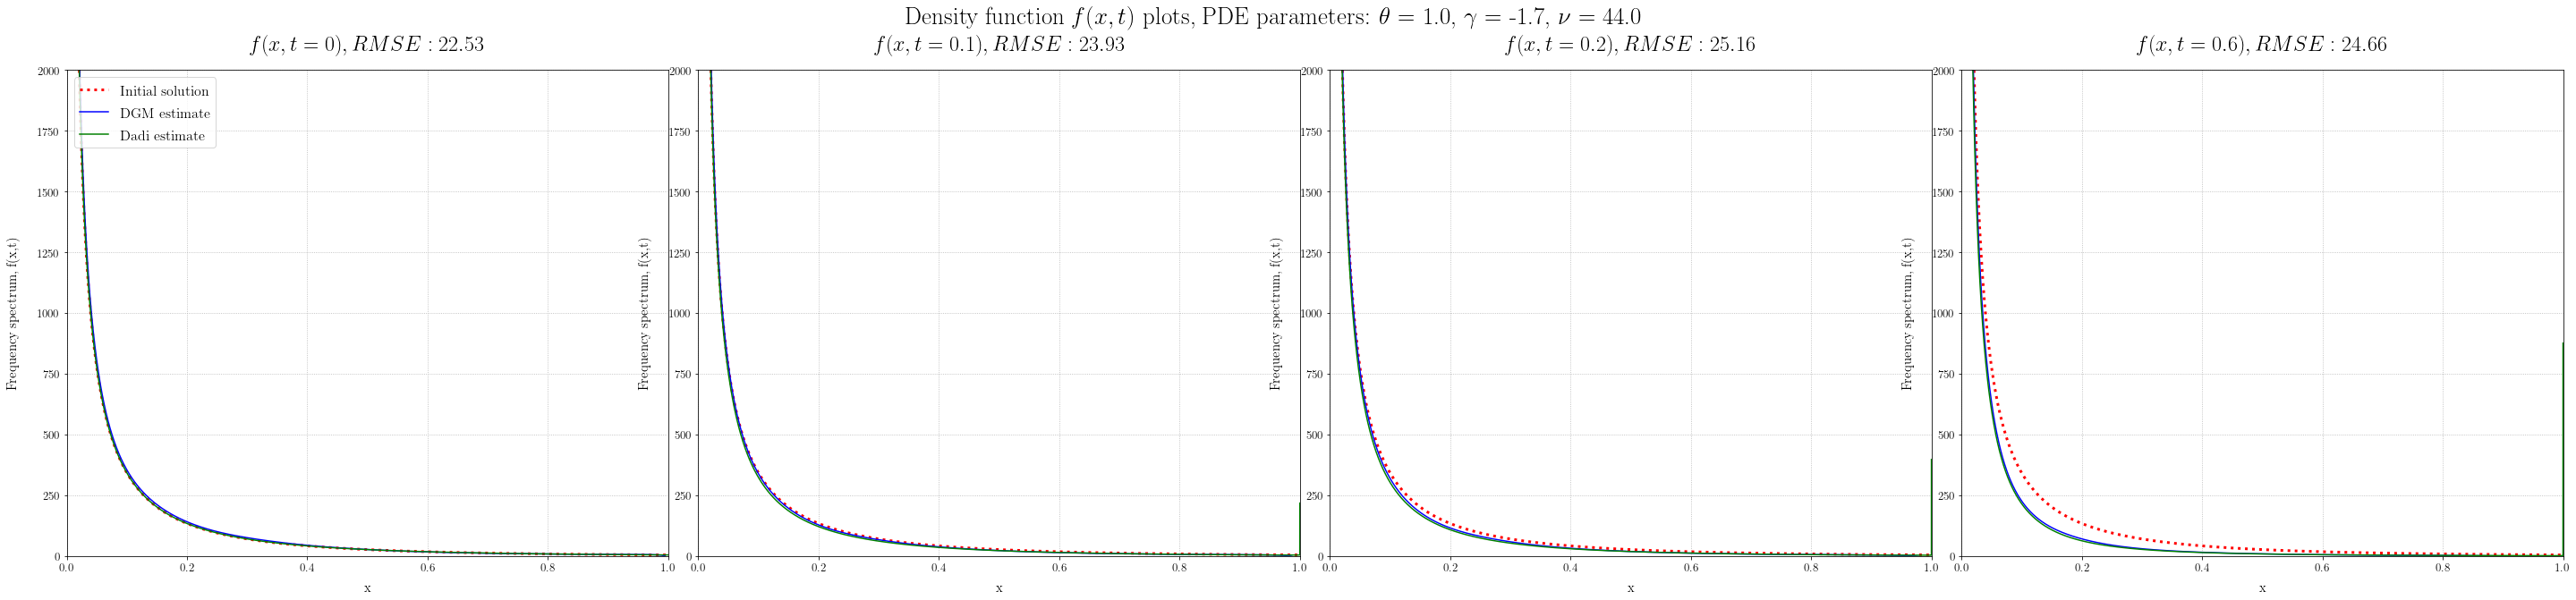

<Figure size 432x288 with 0 Axes>

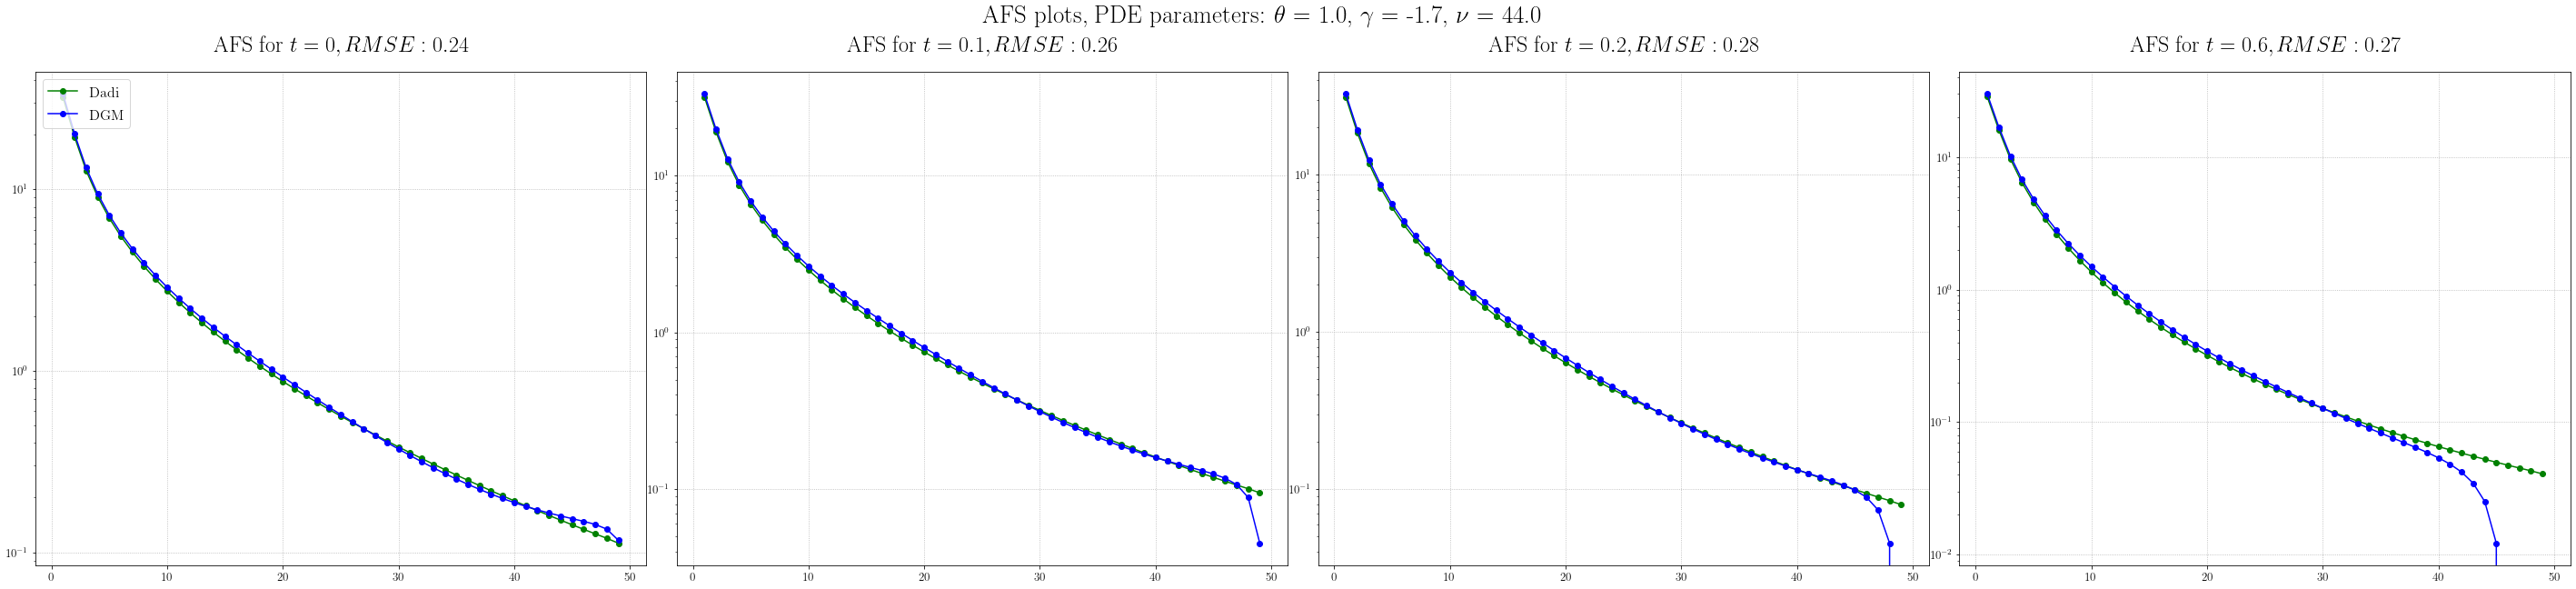

In [75]:
PlotSolutions(theta = 1.0, gamma =  -1.7, nu = 44.0)
PlotSolutions(1.0, -1.7, 44.0, plot_afs=True)